# Customer Assignment Model

The goal of this model is to pick a set of retail store locations, chosen from among a set of candidate locations, to maximize the total number of potential customers.  The likelihood that a customer visits a store is assumed to decrease as the distance from that customer to the nearest store increases.

## Define model parameters

Number of customers, number of candidate store locations, number of stores to build (from among the candidate locations), and number of clusters to group the customers into.  Feel free to modify any of these.

In [1]:
ncustomers = 50000
nstorecands = 50
nstores = 8
nclusters = 1000

## Determine customer and candidate store locations

In this simple example, we choose random locations for customers and store candidates.  Customers are distributed using Gaussian distributions around a few randomly chosen population centers.  Store locations are uniformly distributed.

In [2]:
import random
random.seed(1)
customers = []
ncenters = 10
for i in range(ncenters):
    center = (random.random()-0.5, random.random()-0.5)
    count = int((i+1)*ncustomers/ncenters) - len(customers)
    customers += [(random.gauss(0,.1) + center[0], random.gauss(0,.1) + center[1]) for i in range(count)]
storecands = [(random.random()-0.5,random.random()-0.5) for i in range(nstorecands)]
print('First customer location:', customers[0])

First customer location: (-0.35900217499377257, 0.2709793718400695)


## Create clusters

To limit the size of the optimization model, we group individual customers into clusters and optimize on these clusters.  Clusters are computed using the K-Means algorithm (as implemented in the scikit-learn package).

In [3]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np

kmeans = MiniBatchKMeans(n_clusters=nclusters, init_size=3*nclusters).fit(customers)
members = list(kmeans.labels_)
clusters = list(kmeans.cluster_centers_) # Center point for each cluster
weights = list(np.histogram(members, bins=nclusters)[0]) # Number of customers in each cluster
print('First cluster center:', clusters[0])
print('Weights for first 10 clusters:', weights[:10])

First cluster center: [-0.46785392  0.32856046]
Weights for first 10 clusters: [61, 79, 79, 35, 17, 77, 51, 27, 61, 95]


## Define store attraction function

Trivial attraction model - the further away the store is, the less attractive it is to the customer.

In [4]:
import math
def attraction(pt1, pt2):
    diff = (pt1[0]-pt2[0], pt1[1]-pt2[1])
    distance = math.sqrt(diff[0]*diff[0]+diff[1]*diff[1])
    return 1.0/(distance+0.01)

## Filter viable customer-store pairings

Collect viable pairings - some stores are just too far away from a customer to be relevant. Threshold is heuristic and arbitrary.

In [5]:
pairings = [(store, cluster) for store in range(len(storecands)) for cluster in range(len(clusters)) \
            if attraction(storecands[store], clusters[cluster]) > 1]
print('Number of viable pairings: %g' % len(pairings))

Number of viable pairings: 46117


## Build optimization model

Pick stores from among candidate locations to maximize total customer attraction.

In [6]:
from gurobipy import *
m = Model()

# Decision variables: select store locations
select = m.addVars(range(len(storecands)), vtype=GRB.BINARY, name='select')
# Decision variables: assign customer clusters to a store location
assign = m.addVars(pairings, vtype=GRB.BINARY, name='assign')

# Objection: maximize total attractiveness to customers
obj = sum(attraction(storecands[p[0]], clusters[p[1]])*weights[p[1]]*assign[p] for p in pairings)
m.setObjective(obj, GRB.MAXIMIZE)

# Constraint: limit number of stores built
m.addConstr(select.sum() <= nstores)

# Constraints: can't assign a customer cluster to a store unless we build the store
m.addConstrs(assign[p] <= select[p[0]] for p in pairings)

# Constraints: customer cluster can be assigned to at most one store
m.addConstrs(assign.sum('*', cluster) <= 1 for cluster in range(len(clusters)))

m.optimize()

Optimize a model with 47118 rows, 46167 columns and 138401 nonzeros
Variable types: 0 continuous, 46167 integer (46167 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 9e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 51 rows and 50 columns
Presolve time: 0.22s
Presolved: 47067 rows, 46117 columns, 138251 nonzeros
Variable types: 0 continuous, 46117 integer (46117 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 5.030274e+05, 4478 iterations, 0.51 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    503027.40166 503027.402  0.00%     -    0s

Explored 0 nodes (4478 simplex iterations) in 0

## Plot results

Show a map of customers (small red dots), customer clusters (large red dots), selected store locations (green dots with incident lines), and customers likely to be attracted to those stores (lines).

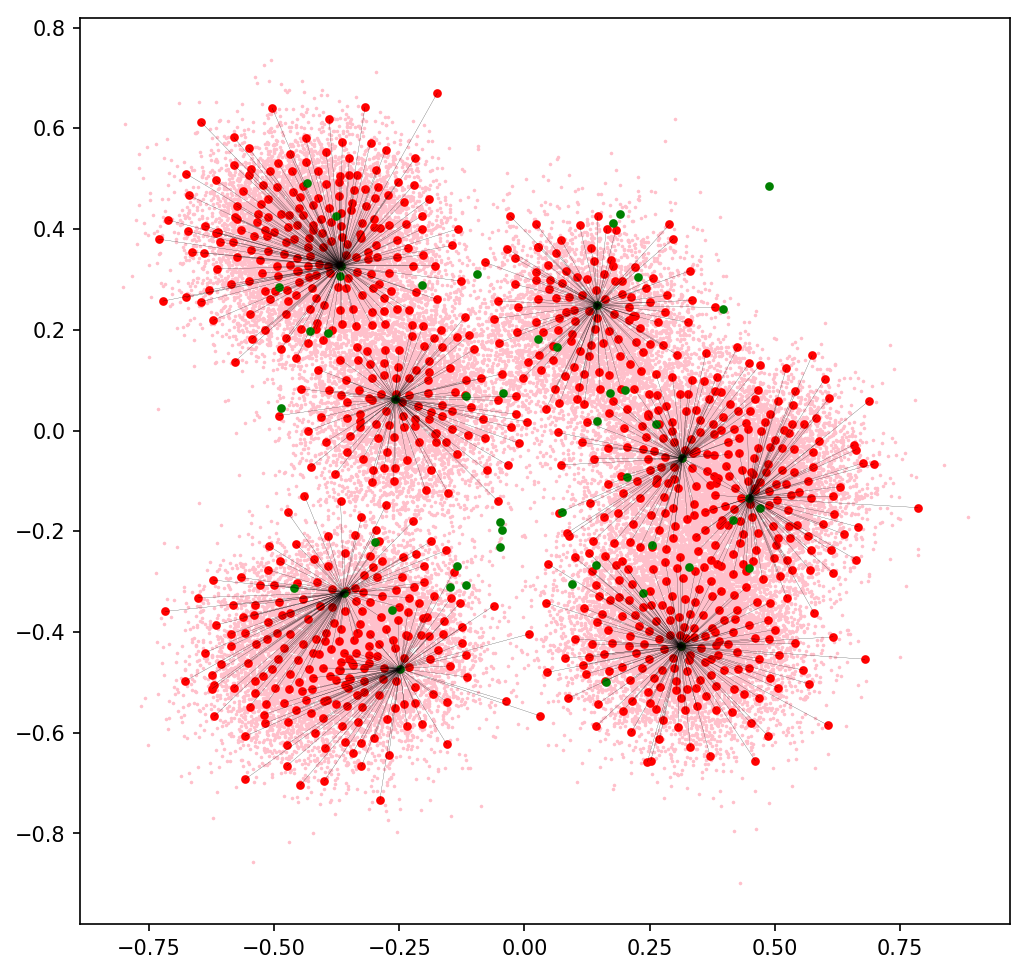

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8),dpi=150)
plt.scatter(*zip(*customers), c='Pink', s=0.5)
plt.scatter(*zip(*clusters), c='Red', s=10)
plt.scatter(*zip(*storecands), c='Green', s=10)
assignments = [p for p in pairings if assign[p].x > 0.5]
for p in assignments:
    pts = [storecands[p[0]], clusters[p[1]]]
    plt.plot(*zip(*pts), c='Black', linewidth=0.1)

Copyright © 2019 Gurobi Optimization, LLC